In [1]:
import numpy as np
import roboticstoolbox as rtb
from spatialmath import SE3, SO3
from scipy.interpolate import CubicSpline
from roboticstoolbox.backends.swift import Swift
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
from spatialgeometry import Cuboid
import random

Robot in the envirnoment

In [2]:
env = Swift()

env.launch(realtime=True, comms="rtc")

panda = rtb.models.Panda()

# Define home configuration (ready pose, 7 joint angles in radians)
q_home = np.array([0, -np.pi/4, 0, -3*np.pi/4, 0, np.pi/2, np.pi/4])

env.add(panda)

terrain_bounds = {
    "x_min": 0.2, "x_max": 0.6,  # X range on the terrain
    "y_min": -0.8, "y_max": 0.8  # Y range on the terrain
}

# Create a colored plane to represent the reachable terrain
terrain = Cuboid(
    [terrain_bounds['x_max'] - terrain_bounds['x_min'], 
     terrain_bounds['y_max'] - terrain_bounds['y_min'], 
     0.001],  
    pose=SE3((terrain_bounds['x_min'] + terrain_bounds['x_max']) / 2, 
             (terrain_bounds['y_min'] + terrain_bounds['y_max']) / 2, 
             0),  # Centered at the middle of the bounds
    color=[0.5, 0.5, 0.5, 0.3]  # Light gray with transparency
)

env.add(terrain)

1

Objects in the environment

In [3]:
# Define cube dimensions and positions
cube_size = 0.06  
cube_height = cube_size
cube_center_z = cube_size / 2  

# Height for picking: top of the cube
pick_z = cube_center_z + cube_height / 2  

# Define pick and place positions for cubes
objects = {
    'red':    (np.array([0.5,  0.25, pick_z]), np.array([0.25, -0.35, pick_z])),
    'blue':   (np.array([0.5,  0.13, pick_z]), np.array([0.25, -0.47, pick_z])),
    'green':  (np.array([0.5,  0.01, pick_z]), np.array([0.25, -0.59, pick_z])),
    'yellow': (np.array([0.5, -0.11, pick_z]), np.array([0.25, -0.71, pick_z])),
}


print(f"Cube size: {cube_size}m")
print(f"Pick/Place height: z={pick_z:.3f}m")
print(f"Objects to sort: {len(objects)}")

for name, (pick, place) in objects.items():
    print(f"  {name}: pick={pick}, place={place}")

# Create visible cube objects in vertical line
bin_red = Cuboid([cube_size, cube_size, cube_size], 
                 pose=SE3(0.5, 0.25, cube_center_z), color=[1, 0, 0, 0.8])      
bin_blue = Cuboid([cube_size, cube_size, cube_size], 
                  pose=SE3(0.5, 0.13, cube_center_z), color=[0, 0, 1, 0.8])     
bin_green = Cuboid([cube_size, cube_size, cube_size], 
                   pose=SE3(0.5, 0.01, cube_center_z), color=[0, 1, 0, 0.8])    
bin_yellow = Cuboid([cube_size, cube_size, cube_size], 
                    pose=SE3(0.5, -0.11, cube_center_z), color=[1, 1, 0, 0.8])  


env.add(bin_red)
env.add(bin_blue)
env.add(bin_green)
env.add(bin_yellow)

print("Objects added to Swift in vertical line")

Cube size: 0.06m
Pick/Place height: z=0.060m
Objects to sort: 4
  red: pick=[0.5  0.25 0.06], place=[ 0.25 -0.35  0.06]
  blue: pick=[0.5  0.13 0.06], place=[ 0.25 -0.47  0.06]
  green: pick=[0.5  0.01 0.06], place=[ 0.25 -0.59  0.06]
  yellow: pick=[ 0.5  -0.11  0.06], place=[ 0.25 -0.71  0.06]
Objects added to Swift in vertical line


In [4]:
def is_within_bounds(position, bounds, plate_size):
        """Ensure the plate's center does not exceed the bounds."""
        x, y = position[:2]
        return (
            bounds['x_min'] + plate_size / 2 <= x <= bounds['x_max'] - plate_size / 2 and
            bounds['y_min'] + plate_size / 2 <= y <= bounds['y_max'] - plate_size / 2
        )

def generate_unique_positions(num_positions, bounds, min_distance, plate_center_z, plate_size):
    """Generate unique positions for objects within bounds."""
    positions = []
    attempts = 0
    max_attempts = 100  # Prevent infinite loops

    while len(positions) < num_positions and attempts < max_attempts:
        new_pos = np.array([
            random.uniform(bounds['x_min'], bounds['x_max']),
            random.uniform(bounds['y_min'], bounds['y_max']),
            plate_center_z
        ])
        if (
            is_within_bounds(new_pos, bounds, plate_size) and
            all(np.linalg.norm(new_pos[:2] - pos[:2]) >= min_distance for pos in positions)
        ):
            positions.append(new_pos)
        attempts += 1

    if len(positions) < num_positions:
        raise ValueError("Could not generate enough unique positions within the bounds and constraints.")

    return positions

In [5]:
# Define the size and positions of the plates
plate_size = 0.1
plate_height = 0.005  
plate_center_z = plate_height / 2  # Center of the plate

# Generate unique positions for the plates
min_distance_between_plates = plate_size * 1.5  # Ensure plates don't overlap
plate_positions = generate_unique_positions(4, terrain_bounds, min_distance_between_plates, plate_center_z, plate_size)

plates = {
    'red': plate_positions[0],
    'blue': plate_positions[1],
    'green': plate_positions[2],
    'yellow': plate_positions[3],
}

# Create visible plate objects in the environment
plate_red = Cuboid([plate_size, plate_size, plate_height], 
                   pose=SE3(*plates['red']), color=[1, 0, 0, 0.5])      
plate_blue = Cuboid([plate_size, plate_size, plate_height], 
                    pose=SE3(*plates['blue']), color=[0, 0, 1, 0.5])     
plate_green = Cuboid([plate_size, plate_size, plate_height], 
                     pose=SE3(*plates['green']), color=[0, 1, 0, 0.5])    
plate_yellow = Cuboid([plate_size, plate_size, plate_height], 
                      pose=SE3(*plates['yellow']), color=[1, 1, 0, 0.5])  

env.add(plate_red)
env.add(plate_blue)
env.add(plate_green)
env.add(plate_yellow)

print("Plates added to Swift with randomized non-overlapping positions")

Plates added to Swift with randomized non-overlapping positions


# Compute the trajectory that the robot need to do for picking 

## Functions

non molto bene

In [6]:
def compute_ik(panda, position, z_offset=0.0): 
    """Compute IK for a position slightly above the object"""
    target = np.array(position).copy()
    target[2] += z_offset      
    
    pose = SE3(target[0], target[1], target[2]) * SE3.Rx(np.pi)
    
    # result = panda.ikine_LM(pose, q0=q_home, joint_limits=True)
    result = panda.ikine_LM(pose, q0=q_home)

    return result.q, result.success

# COMMENTED OUT: Joint-space motion control
# def make_traj(q_start, q_goal, duration=2.0, n_points=100):
#     """Generate a smooth joint-space trajectory from q_start to q_goal."""
#     t = np.linspace(0, duration, n_points)          # time vector
#     traj = np.zeros((n_points, 7))                  # 7 joints
#     
#     for i in range(7):
#         # cubic spline between start and goal for joint i
#         cs = CubicSpline([0, duration], [q_start[i], q_goal[i]])
#         traj[:, i] = cs(t)
#     
#     return traj

def move_to_pose_rrmc(panda, target_pose, q_current, dt=0.01, position_tol=0.001, orientation_tol=0.01, max_iterations=1000, lambda_damping=0.01):
    """
    Move the robot end-effector to a target pose using RRMC (Resolved Rate Motion Control).
    Uses Jacobian pseudo-inverse for Cartesian velocity control.
    
    Args:
        panda: Robot model
        target_pose: SE3 object representing the target pose
        q_current: Current joint configuration
        dt: Time step for integration
        position_tol: Position error tolerance (m)
        orientation_tol: Orientation error tolerance (rad)
        max_iterations: Maximum number of iterations
        lambda_damping: Damping factor for pseudo-inverse
    
    Returns:
        q_final: Final joint configuration
        success: Boolean indicating if target was reached
    """
    q = q_current.copy()
    
    for i in range(max_iterations):
        # Get current end-effector pose
        T_current = panda.fkine(q)
        
        # Compute pose error
        T_error = target_pose * T_current.inv()
        
        # Extract position error
        position_error = T_error.t
        
        # Extract orientation error (axis-angle representation)
        # Use the logarithm of rotation matrix to get angular velocity
        R_error = T_error.R
        angle = np.arccos(np.clip((np.trace(R_error) - 1) / 2, -1, 1))
        
        if angle < 1e-6:
            orientation_error = np.zeros(3)
        else:
            axis = np.array([
                R_error[2, 1] - R_error[1, 2],
                R_error[0, 2] - R_error[2, 0],
                R_error[1, 0] - R_error[0, 1]
            ]) / (2 * np.sin(angle))
            orientation_error = angle * axis
        
        # Combine position and orientation errors
        spatial_error = np.concatenate([position_error, orientation_error])
        
        # Check if we've reached the target
        if np.linalg.norm(position_error) < position_tol and np.linalg.norm(orientation_error) < orientation_tol:
            return q, True
        
        # Compute Jacobian
        J = panda.jacob0(q)
        
        # Compute damped pseudo-inverse (more stable than pure pseudo-inverse)
        J_damped = J.T @ np.linalg.inv(J @ J.T + lambda_damping**2 * np.eye(6))
        
        # Compute desired Cartesian velocity (proportional control)
        K = 1.0  # Proportional gain
        v_desired = K * spatial_error
        
        # Compute joint velocities
        q_dot = J_damped @ v_desired
        
        # Integrate to get new joint configuration
        q = q + q_dot * dt
        
    return q, False  # Did not converge

## Dictionary with trajectory

In [7]:
approach_height = 0.12 

trajectories = {}

# RRMC: Store target poses and initial IK solutions instead of joint-space trajectories
for name, (pick_pos, _) in objects.items():
    print(f"[INFO] Computing trajectory for {name}...")
    
    # Get the plate position for placing
    place_pos = plates[name]

    # Adjust the cube's center to be above the plate by half the cube's height
    adjusted_place_pos = place_pos.copy()
    adjusted_place_pos[2] = max(plate_center_z + cube_height, adjusted_place_pos[2])

    # Create SE3 poses for each target position
    pose_pick_above = SE3(pick_pos[0], pick_pos[1], pick_pos[2] + approach_height) * SE3.Rx(np.pi)
    pose_pick = SE3(pick_pos[0], pick_pos[1], pick_pos[2]) * SE3.Rx(np.pi)
    pose_place_above = SE3(adjusted_place_pos[0], adjusted_place_pos[1], adjusted_place_pos[2] + approach_height) * SE3.Rx(np.pi)
    pose_place = SE3(adjusted_place_pos[0], adjusted_place_pos[1], adjusted_place_pos[2]) * SE3.Rx(np.pi)
    pose_home = panda.fkine(q_home)
    
    # IK for verification only - RRMC will compute the actual path using Jacobian
    # These IK solutions verify that the target poses are reachable
    q_pick_above, ok1 = compute_ik(panda, pick_pos, z_offset=approach_height)
    q_pick,       ok2 = compute_ik(panda, pick_pos, z_offset=0.0)
    q_place_above, ok3 = compute_ik(panda, adjusted_place_pos, z_offset=approach_height)
    q_place,       ok4 = compute_ik(panda, adjusted_place_pos, z_offset=0.0)
    
    if not (ok1 and ok2 and ok3 and ok4):
        print(f"[ERROR] IK failed for {name} (ok1={ok1}, ok2={ok2}, ok3={ok3}, ok4={ok4})")
        print(f"  Pick position: {pick_pos}")
        print(f"  Place position: {adjusted_place_pos}")
        print(f"[WARNING] Skipping {name} - will not be processed")
        continue
    
    print(f"[SUCCESS] IK solutions found for {name}")

    # COMMENTED OUT: Joint-space trajectories
    # traj_home_to_pick_above      = make_traj(q_home,        q_pick_above)
    # traj_pick_above_to_pick      = make_traj(q_pick_above,  q_pick)
    # traj_pick_to_pick_above      = make_traj(q_pick,        q_pick_above)
    # traj_pick_above_to_place_abv = make_traj(q_pick_above,  q_place_above)
    # traj_place_abv_to_place      = make_traj(q_place_above, q_place)
    # traj_place_to_place_abv      = make_traj(q_place,       q_place_above)
    # traj_place_abv_to_home       = make_traj(q_place_above, q_home)

    # Save target poses and IK solutions for RRMC
    trajectories[name] = {
        "poses": {
            "home": pose_home,
            "pick_above": pose_pick_above,
            "pick": pose_pick,
            "place_above": pose_place_above,
            "place": pose_place,
        },
        "ik_solutions": {
            "home": q_home,
            "pick_above": q_pick_above,
            "pick": q_pick,
            "place_above": q_place_above,
            "place": q_place,
        }
    }

# Summary
print(f"\n{'='*60}")
print(f"Trajectory Generation Complete")
print(f"{'='*60}")
print(f"Total objects: {len(objects)}")
print(f"Successfully computed: {len(trajectories)}")
print(f"Failed: {len(objects) - len(trajectories)}")
if len(trajectories) > 0:
    print(f"Ready to execute: {', '.join(trajectories.keys())}")
else:
    print("[ERROR] No trajectories computed! Check IK failures.")
print(f"{'='*60}")

[INFO] Computing trajectory for red...


[SUCCESS] IK solutions found for red
[INFO] Computing trajectory for blue...
[SUCCESS] IK solutions found for blue
[INFO] Computing trajectory for green...
[SUCCESS] IK solutions found for green
[INFO] Computing trajectory for yellow...
[SUCCESS] IK solutions found for blue
[INFO] Computing trajectory for green...
[SUCCESS] IK solutions found for green
[INFO] Computing trajectory for yellow...
[SUCCESS] IK solutions found for yellow

Trajectory Generation Complete
Total objects: 4
Successfully computed: 4
Failed: 0
Ready to execute: red, blue, green, yellow
[SUCCESS] IK solutions found for yellow

Trajectory Generation Complete
Total objects: 4
Successfully computed: 4
Failed: 0
Ready to execute: red, blue, green, yellow


## Do the movement

In [8]:
# Map each logical object name to its visual Cuboid in Swift
cube_objs = {
    'red': bin_red,
    'blue': bin_blue,
    'green': bin_green,
    'yellow': bin_yellow
}

In [ ]:
# COMMENTED OUT: Joint-space motion control execution
# def execute_pick_and_place(name, sleep_dt=0.02):
#     """
#     Execute the joint-space trajectories for one object and
#     visually attach/detach the cube to the robot gripper.
#     """
#     cube = cube_objs[name]      # visual cube object
#     trajs = trajectories[name]  # all phases for this object
#
#     try:
#         # 1) Home -> pick_above (robot approaches, cube stationary)
#         for q in trajs["home_to_pick_above"]:
#             panda.q = q
#             env.step(0.01)
#             time.sleep(sleep_dt)
#
#         # 2) pick_above -> pick (descending, cube still stationary) 
#         # Calculate the relative transformation hand->cube at the end
#         last_q_contact = trajs["pick_above_to_pick"][-1]
#         for q in trajs["pick_above_to_pick"]:
#             panda.q = q
#             env.step(0.01)
#             time.sleep(sleep_dt)
#
#         # Pose of the hand and cube at the moment of "contact"
#         T_ee_contact   = panda.fkine(last_q_contact)  # end-effector pose at contact
#         T_cube_contact = cube.T                       # cube pose on the table
#         T_rel = T_ee_contact.inv() * T_cube_contact  # rigid transform hand -> cube
#
#         # 3) pick -> pick_above (cube ATTACHED to the gripper) 
#         for q in trajs["pick_to_pick_above"]:
#             panda.q = q
#             T_ee = panda.fkine(q)
#             cube.T = T_ee * T_rel                    # cube follows the hand rigidly
#             env.step(0.01)
#             time.sleep(sleep_dt)
#
#         # 4) pick_above -> place_above (transport in air with cube attached)
#         for q in trajs["pick_above_to_place_abv"]:
#             panda.q = q
#             T_ee = panda.fkine(q)
#             cube.T = T_ee * T_rel
#             env.step(0.01)
#             time.sleep(sleep_dt)
#
#         # 5) place_above -> place (descending to place the cube)
#         last_q_place = trajs["place_abv_to_place"][-1]
#         for q in trajs["place_abv_to_place"]:
#             panda.q = q
#             T_ee = panda.fkine(q)
#             cube.T = T_ee * T_rel
#             env.step(0.01)
#             time.sleep(sleep_dt)
#
#         # Force the cube exactly into the place position
#         place_pos = plates[name]  # Use the plate's position 
#         cube.T = SE3(place_pos[0], place_pos[1], cube_center_z)
#
#         # 6) place -> place_above (gripper rises, cube STAYS on the table) 
#         for q in trajs["place_to_place_abv"]:
#             panda.q = q
#             # Do not update cube.T: the cube stays where we left it
#             env.step(0.01)
#             time.sleep(sleep_dt)
#
#         # 7) place_above -> home (robot returns to home)
#         for q in trajs["place_abv_to_home"]:
#             panda.q = q
#             env.step(0.01)
#             time.sleep(sleep_dt)
#
#     except Exception as e:
#         print(f"[ERROR] Failed to execute pick-and-place for {name}: {e}")

def execute_pick_and_place_rrmc(name, sleep_dt=0.02, update_freq=10):
    """
    Execute RRMC (Resolved Rate Motion Control) for one object using Cartesian velocity control.
    Uses Jacobian pseudo-inverse to smoothly reach pick and place poses in operational space.
    
    Args:
        name: Object name (color)
        sleep_dt: Sleep time between visualization updates (0.02 matches joint-space speed)
        update_freq: Frequency of updating visualization (higher = less smooth, more discrete)
    """
    cube = cube_objs[name]
    traj_data = trajectories[name]
    poses = traj_data["poses"]
    
    try:
        q_current = q_home.copy()
        
        # Helper function to execute RRMC motion with visualization
        def rrmc_move_with_viz(target_pose, q_start, cube_attached=False, T_rel=None):
            q = q_start.copy()
            dt = 0.05  # Larger time step for slower, smoother motion
            max_iter = 2000  # Increased to allow convergence with larger dt
            pos_tol = 0.001
            ori_tol = 0.01
            lambda_damping = 0.01
            K = 0.5  # Reduced gain for slower, more controlled motion
            
            for i in range(max_iter):
                T_current = panda.fkine(q)
                T_error = target_pose * T_current.inv()
                position_error = T_error.t
                
                R_error = T_error.R
                angle = np.arccos(np.clip((np.trace(R_error) - 1) / 2, -1, 1))
                
                if angle < 1e-6:
                    orientation_error = np.zeros(3)
                else:
                    axis = np.array([
                        R_error[2, 1] - R_error[1, 2],
                        R_error[0, 2] - R_error[2, 0],
                        R_error[1, 0] - R_error[0, 1]
                    ]) / (2 * np.sin(angle))
                    orientation_error = angle * axis
                
                if np.linalg.norm(position_error) < pos_tol and np.linalg.norm(orientation_error) < ori_tol:
                    return q, True
                
                spatial_error = np.concatenate([position_error, orientation_error])
                J = panda.jacob0(q)
                J_damped = J.T @ np.linalg.inv(J @ J.T + lambda_damping**2 * np.eye(6))
                v_desired = K * spatial_error
                q_dot = J_damped @ v_desired
                q = q + q_dot * dt
                
                # Update visualization periodically
                if i % update_freq == 0:
                    panda.q = q
                    if cube_attached and T_rel is not None:
                        T_ee = panda.fkine(q)
                        cube.T = T_ee * T_rel
                    env.step(0.01)
                    time.sleep(sleep_dt)
            
            return q, False
        
        print(f"[RRMC] {name}: Moving to pick_above")
        # 1) Home -> pick_above
        q_current, success = rrmc_move_with_viz(poses["pick_above"], q_current)
        if not success:
            print(f"[WARNING] {name}: Did not fully converge to pick_above")
        
        print(f"[RRMC] {name}: Descending to pick")
        # 2) pick_above -> pick (descending to grasp)
        q_current, success = rrmc_move_with_viz(poses["pick"], q_current)
        if not success:
            print(f"[WARNING] {name}: Did not fully converge to pick")
        
        # Calculate relative transform for cube attachment
        T_ee_contact = panda.fkine(q_current)
        T_cube_contact = cube.T
        T_rel = T_ee_contact.inv() * T_cube_contact
        
        print(f"[RRMC] {name}: Lifting with cube attached")
        # 3) pick -> pick_above (lifting with cube)
        q_current, success = rrmc_move_with_viz(poses["pick_above"], q_current, cube_attached=True, T_rel=T_rel)
        if not success:
            print(f"[WARNING] {name}: Did not fully converge back to pick_above")
        
        print(f"[RRMC] {name}: Transporting to place_above")
        # 4) pick_above -> place_above (transporting)
        q_current, success = rrmc_move_with_viz(poses["place_above"], q_current, cube_attached=True, T_rel=T_rel)
        if not success:
            print(f"[WARNING] {name}: Did not fully converge to place_above")
        
        print(f"[RRMC] {name}: Descending to place")
        # 5) place_above -> place (placing down)
        q_current, success = rrmc_move_with_viz(poses["place"], q_current, cube_attached=True, T_rel=T_rel)
        if not success:
            print(f"[WARNING] {name}: Did not fully converge to place")
        
        # Place cube at final position
        place_pos = plates[name]
        cube.T = SE3(place_pos[0], place_pos[1], cube_center_z)
        
        print(f"[RRMC] {name}: Retracting gripper")
        # 6) place -> place_above (retracting gripper)
        q_current, success = rrmc_move_with_viz(poses["place_above"], q_current, cube_attached=False)
        if not success:
            print(f"[WARNING] {name}: Did not fully converge back to place_above")
        
        print(f"[RRMC] {name}: Returning to home")
        # 7) place_above -> home (returning to home)
        q_current, success = rrmc_move_with_viz(poses["home"], q_current, cube_attached=False)
        if not success:
            print(f"[WARNING] {name}: Did not fully converge to home")
        
        print(f"[RRMC] {name}: Completed successfully")
        
    except Exception as e:
        print(f"[ERROR] Failed to execute RRMC pick-and-place for {name}: {e}")

In [10]:
# COMMENTED OUT: Joint-space execution
# for name in trajectories.keys():
#     print(f"[INFO] Executing pick-and-place for {name}")
#     execute_pick_and_place(name, sleep_dt=0.02)

# RRMC execution
for idx, name in enumerate(trajectories.keys(), 1):
    print(f"\n[INFO] [{idx}/{len(trajectories)}] Executing RRMC pick-and-place for {name}")
    execute_pick_and_place_rrmc(name)  # Uses default slow speed matching joint-space






[INFO] [1/4] Executing RRMC pick-and-place for red
[RRMC] red: Moving to pick_above
[RRMC] red: Descending to pick
[RRMC] red: Descending to pick
[RRMC] red: Lifting with cube attached
[RRMC] red: Lifting with cube attached
[RRMC] red: Transporting to place_above
[RRMC] red: Transporting to place_above
[RRMC] red: Descending to place
[RRMC] red: Descending to place
[RRMC] red: Retracting gripper
[RRMC] red: Retracting gripper
[RRMC] red: Returning to home
[RRMC] red: Returning to home
[RRMC] red: Completed successfully

[INFO] [2/4] Executing RRMC pick-and-place for blue
[RRMC] blue: Moving to pick_above
[RRMC] red: Completed successfully

[INFO] [2/4] Executing RRMC pick-and-place for blue
[RRMC] blue: Moving to pick_above
[RRMC] blue: Descending to pick
[RRMC] blue: Descending to pick
[RRMC] blue: Lifting with cube attached
[RRMC] blue: Lifting with cube attached
[RRMC] blue: Transporting to place_above
[RRMC] blue: Transporting to place_above
[RRMC] blue: Descending to place
[RRMC]

## Visualization Plots


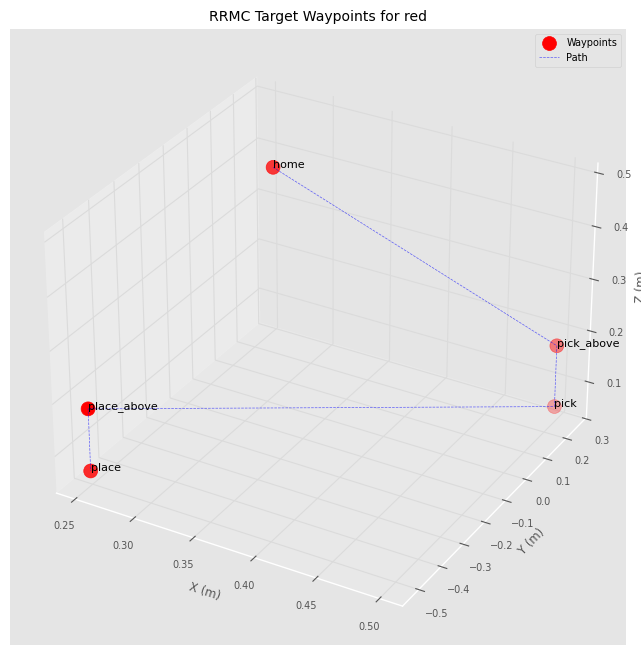

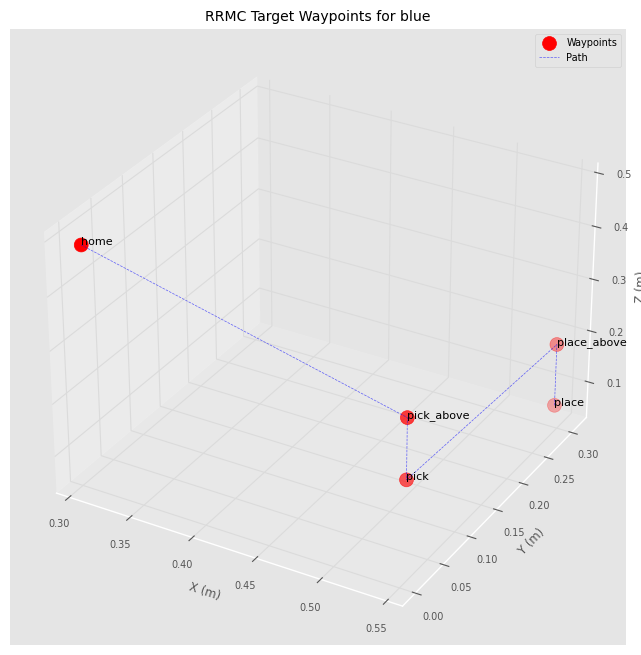

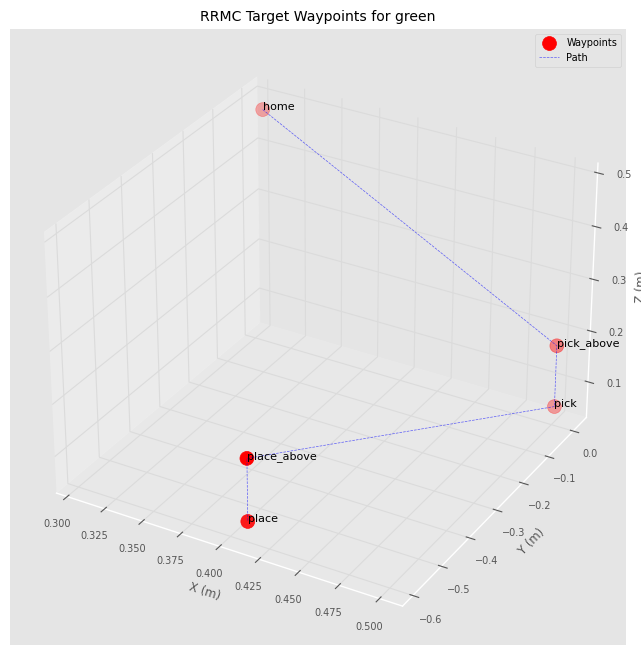

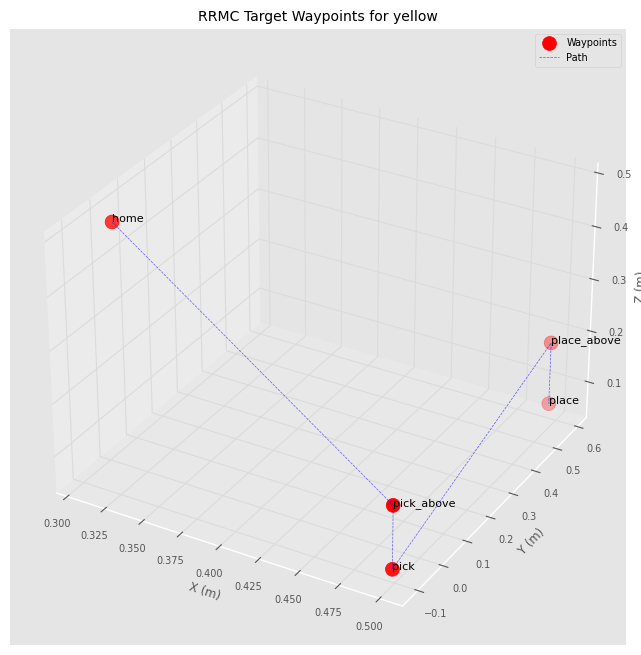

In [11]:
# COMMENTED OUT: Old visualization for joint-space trajectories
# def plot_3d_trajectory_per_cube(trajectories, panda):
#     """Plot the 3D trajectory of the robot's end-effector for each cube without combining trajectories."""
#     for name, traj_dict in trajectories.items():
#         fig = plt.figure(figsize=(10, 8))
#         ax = fig.add_subplot(111, projection='3d')
#
#         for phase, traj in traj_dict.items():
#             ee_positions = []
#             for q in traj:
#                 ee_pose = panda.fkine(q) 
#                 ee_positions.append(ee_pose.t) 
#
#             ee_positions = np.array(ee_positions)
#             ax.plot(ee_positions[:, 0], ee_positions[:, 1], ee_positions[:, 2], label=phase)
#
#         ax.set_title(f"3D Trajectory of End-Effector for {name}")
#         ax.set_xlabel("X (m)")
#         ax.set_ylabel("Y (m)")
#         ax.set_zlabel("Z (m)")
#         ax.legend()
#         plt.show()
#
# plot_3d_trajectory_per_cube(trajectories, panda)

def plot_rrmc_waypoints(trajectories):
    """Plot the target waypoints for RRMC motion for each cube."""
    for name, traj_data in trajectories.items():
        poses = traj_data["poses"]
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Extract positions from poses
        waypoint_names = ["home", "pick_above", "pick", "place_above", "place"]
        positions = []
        
        for wp_name in waypoint_names:
            if wp_name in poses:
                pose = poses[wp_name]
                positions.append(pose.t)
        
        positions = np.array(positions)
        
        # Plot waypoints
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], 
                   c='red', marker='o', s=100, label='Waypoints')
        
        # Plot path connecting waypoints
        ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 
                'b--', alpha=0.6, label='Path')
        
        # Annotate waypoints
        for i, wp_name in enumerate(waypoint_names):
            if i < len(positions):
                ax.text(positions[i, 0], positions[i, 1], positions[i, 2], 
                        wp_name, fontsize=8)
        
        ax.set_title(f"RRMC Target Waypoints for {name}")
        ax.set_xlabel("X (m)")
        ax.set_ylabel("Y (m)")
        ax.set_zlabel("Z (m)")
        ax.legend()
        plt.show()

plot_rrmc_waypoints(trajectories)